# Sleeper Fantasy Analytics — Exploratory Data Analysis

NFL seasons 2020–2024 · Skill positions: QB, RB, WR, TE

**Contents**
1. Setup & data overview
2. Fantasy points distributions
3. Top player rankings
4. Consistency vs output
5. Usage → production (snap share & target share)
6. Week-by-week scoring trends
7. Position scarcity
8. A/B experiment preview

## 1 · Setup & data overview

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="darkgrid", palette="muted")
plt.rcParams["figure.dpi"] = 120

DB_PATH = Path().resolve().parent / "data" / "sleeper_analytics.duckdb"
con = duckdb.connect(str(DB_PATH), read_only=True)

POSITION_COLORS = {"QB": "#e63946", "RB": "#2a9d8f", "WR": "#457b9d", "TE": "#f4a261"}
POSITIONS = ["QB", "RB", "WR", "TE"]

print("Connected to:", DB_PATH)

Connected to: /mnt/data/Exp/sleeper_analytics/data/sleeper_analytics.duckdb


In [2]:
# Table row counts
tables = con.execute("""
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'main'
    ORDER BY table_name
""").df()

for t in tables.table_name:
    n = con.execute(f"SELECT COUNT(*) FROM {t}").fetchone()[0]
    print(f"  {t:<40} {n:>8,} rows")

  ab_assignments                             10,000 rows
  ab_events                                  80,000 rows
  dim_games                                   1,408 rows
  dim_players                                 5,760 rows
  fact_snap_counts                           31,834 rows
  fact_weekly_stats                          26,125 rows
  metrics_player_season                       2,854 rows
  metrics_player_weekly                      26,125 rows
  metrics_position_baseline                     356 rows
  raw_rosters                               229,223 rows
  raw_schedules                               1,408 rows
  raw_snap_counts                           131,003 rows
  raw_weekly_stats                           28,026 rows


In [3]:
# Load key tables
weekly  = con.execute("SELECT * FROM metrics_player_weekly").df()
season  = con.execute("SELECT * FROM metrics_player_season").df()
baseline = con.execute("SELECT * FROM metrics_position_baseline").df()

print(f"Weekly records : {len(weekly):,}")
print(f"Season records : {len(season):,}")
print(f"Seasons covered: {sorted(weekly.season.unique())}")
print(f"\nPosition breakdown:")
print(weekly.groupby('position').size().rename('weekly_records'))

Weekly records : 26,125
Season records : 2,854
Seasons covered: [2020, 2021, 2022, 2023, 2024]

Position breakdown:
position
QB     3262
RB     6781
TE     5347
WR    10735
Name: weekly_records, dtype: int64


## 2 · Fantasy points distributions

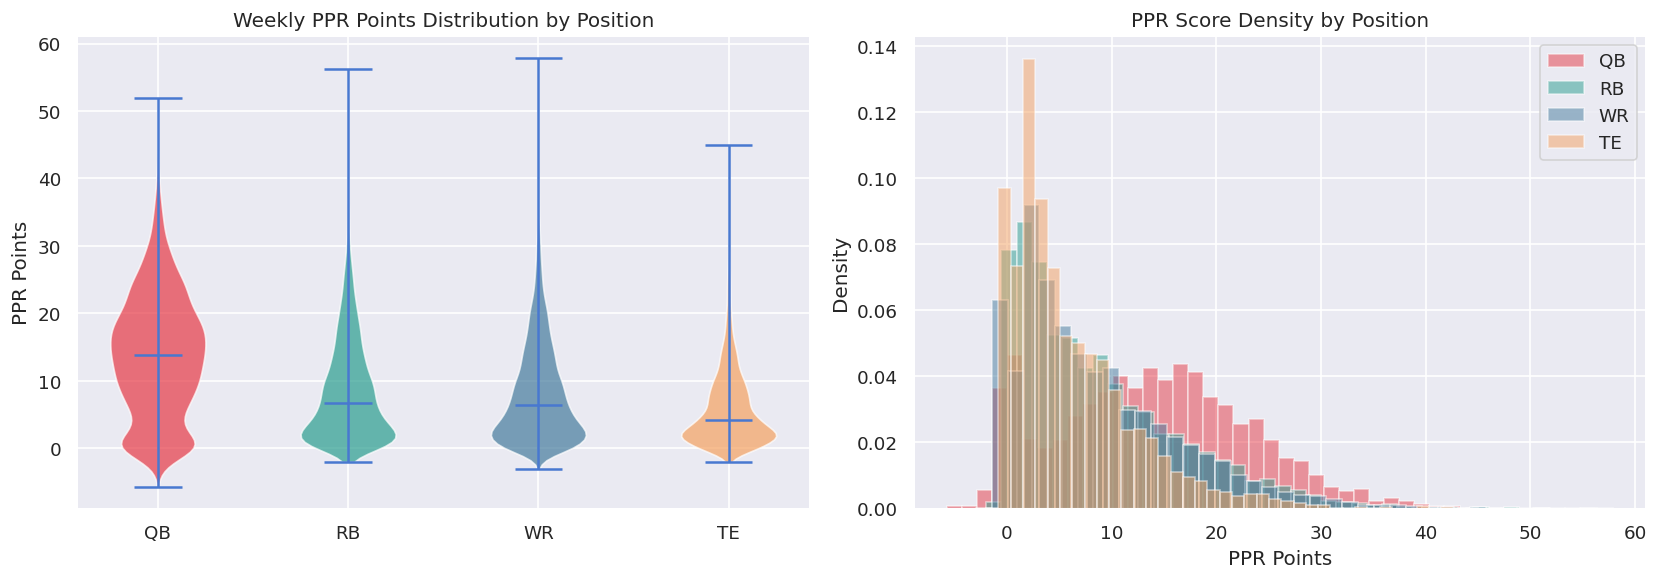

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
QB,3262.0,13.87,9.20,-5.74,7.02,13.84,20.05,51.88
RB,6781.0,8.82,7.97,-2.00,2.40,6.70,13.20,56.20
TE,5347.0,6.14,5.96,-2.00,1.80,4.20,9.00,45.00
WR,10735.0,8.56,7.84,-3.00,2.40,6.40,12.80,57.90


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin — weekly PPR by position
ax = axes[0]
data = [weekly[weekly.position == p].fantasy_points_ppr.dropna() for p in POSITIONS]
parts = ax.violinplot(data, positions=range(len(POSITIONS)), showmedians=True, showextrema=True)
for i, (pc, pos) in enumerate(zip(parts['bodies'], POSITIONS)):
    pc.set_facecolor(POSITION_COLORS[pos])
    pc.set_alpha(0.7)
ax.set_xticks(range(len(POSITIONS)))
ax.set_xticklabels(POSITIONS)
ax.set_title("Weekly PPR Points Distribution by Position")
ax.set_ylabel("PPR Points")

# Histogram — all positions overlaid
ax2 = axes[1]
for pos in POSITIONS:
    vals = weekly[weekly.position == pos].fantasy_points_ppr.dropna()
    ax2.hist(vals, bins=40, alpha=0.5, label=pos,
             color=POSITION_COLORS[pos], density=True)
ax2.set_title("PPR Score Density by Position")
ax2.set_xlabel("PPR Points")
ax2.set_ylabel("Density")
ax2.legend()

plt.tight_layout()
plt.show()

# Summary stats
weekly.groupby('position')['fantasy_points_ppr'].describe().round(2)

## 3 · Top player rankings

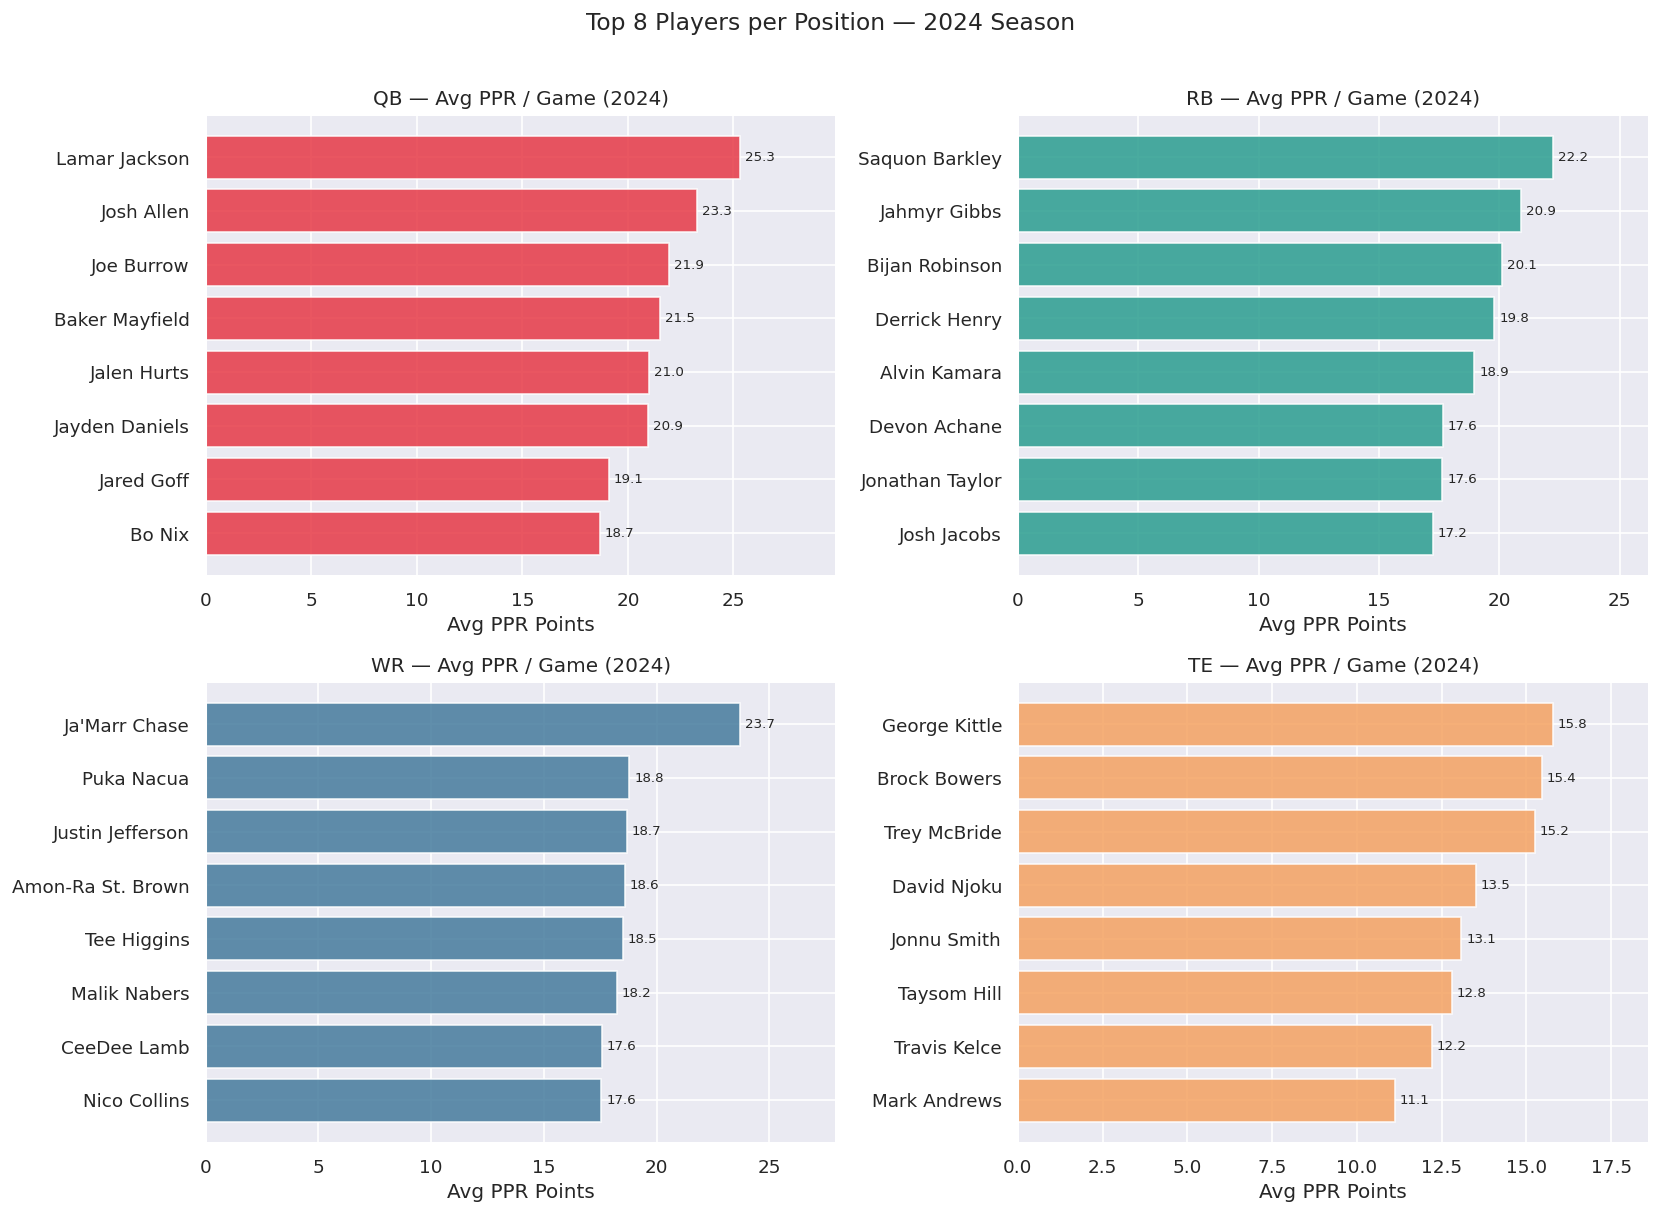

In [5]:
SEASON = 2024
top = (
    season[season.season == SEASON]
    .query("games_played >= 8")
    .sort_values("avg_pts_per_game_ppr", ascending=False)
    .groupby("position")
    .head(8)
    .reset_index(drop=True)
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, pos in zip(axes, POSITIONS):
    df = top[top.position == pos].sort_values("avg_pts_per_game_ppr")
    bars = ax.barh(df.player_name, df.avg_pts_per_game_ppr,
                   color=POSITION_COLORS[pos], alpha=0.85)
    ax.bar_label(bars, fmt="%.1f", padding=3, fontsize=8)
    ax.set_title(f"{pos} — Avg PPR / Game ({SEASON})")
    ax.set_xlabel("Avg PPR Points")
    ax.set_xlim(0, df.avg_pts_per_game_ppr.max() * 1.18)

plt.suptitle(f"Top 8 Players per Position — {SEASON} Season", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 4 · Consistency vs output

**Coefficient of variation (CV)** = std / mean. Lower CV = more consistent week-to-week output.  
Ideal fantasy players sit in the **bottom-right quadrant**: high avg PPR, low CV.

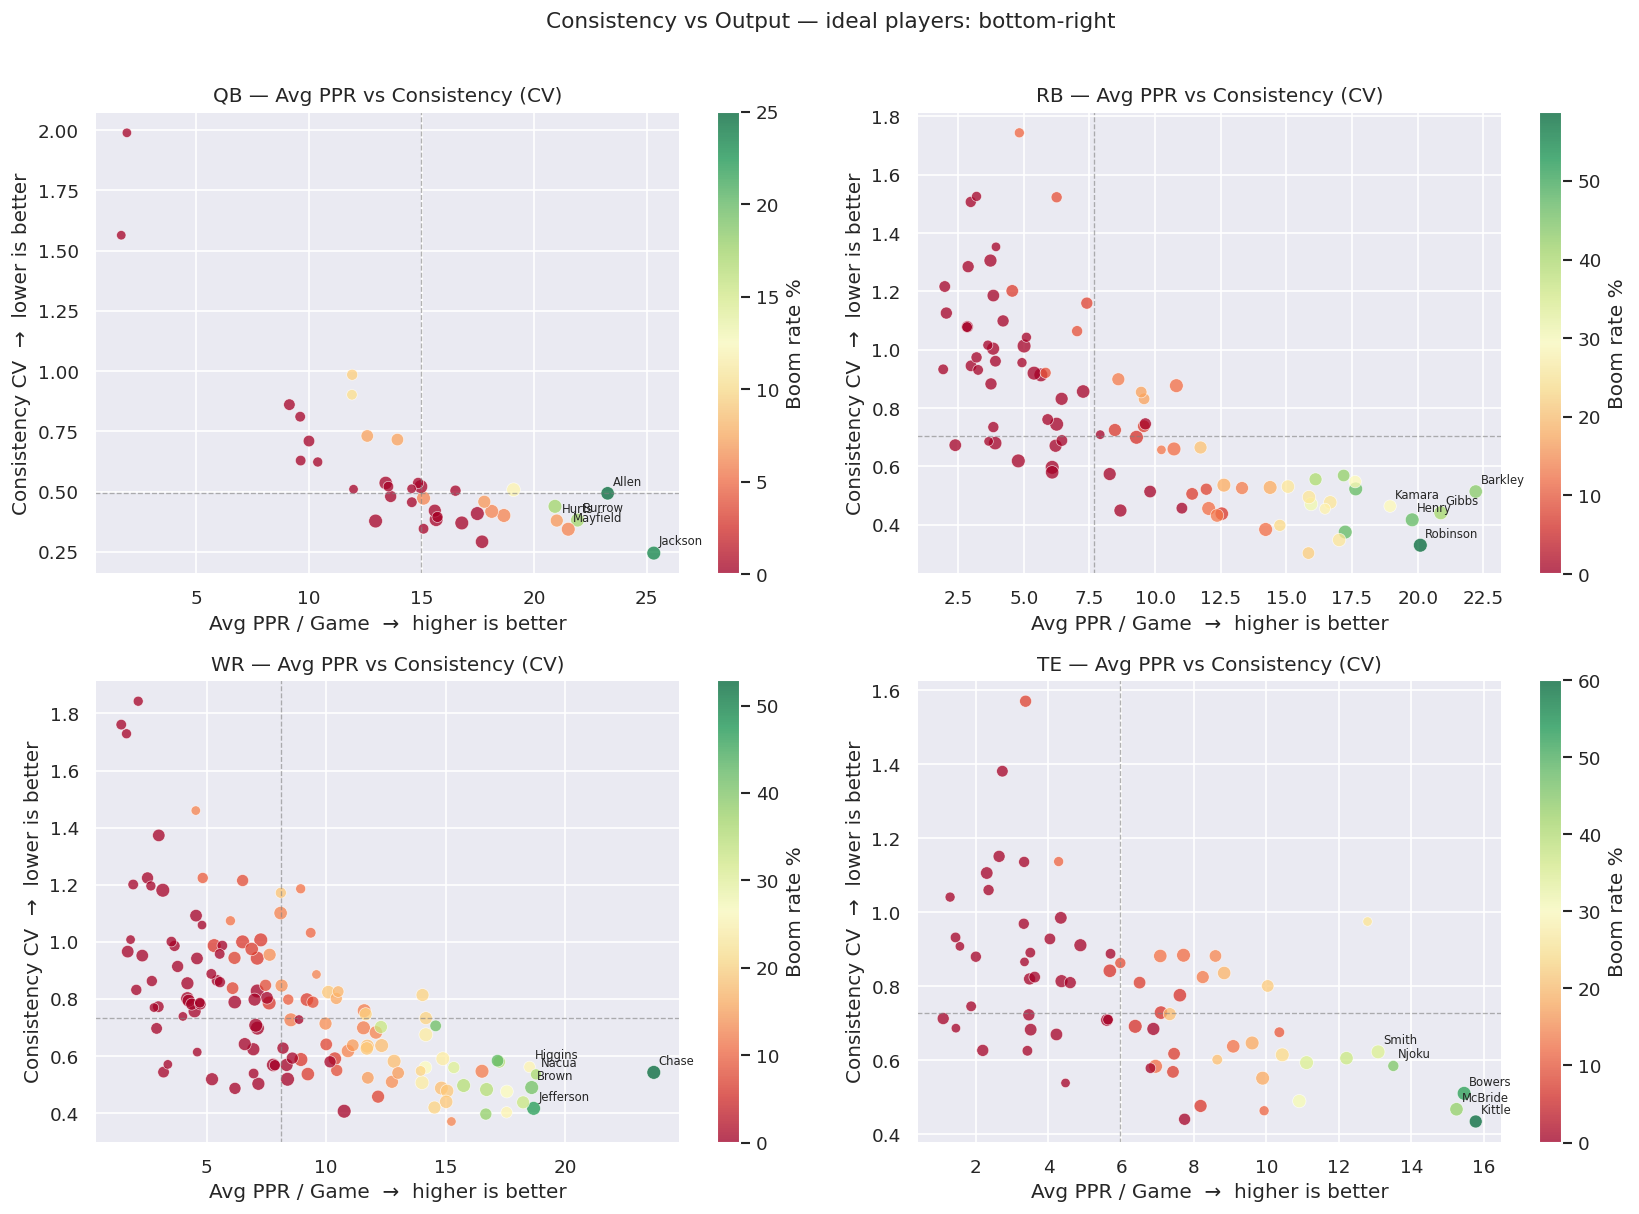

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, pos in zip(axes, POSITIONS):
    df = (
        season[(season.position == pos) & (season.season == SEASON) & (season.games_played >= 8)]
        .dropna(subset=["consistency_cv", "avg_pts_per_game_ppr"])
    )
    sc = ax.scatter(
        df.avg_pts_per_game_ppr, df.consistency_cv,
        c=df.boom_rate_pct, cmap="RdYlGn",
        s=df.games_played * 4, alpha=0.75, edgecolors="white", linewidths=0.4
    )
    plt.colorbar(sc, ax=ax, label="Boom rate %")

    # Label top 5 by avg PPR
    for _, row in df.nlargest(5, "avg_pts_per_game_ppr").iterrows():
        ax.annotate(
            row.player_name.split()[-1], 
            (row.avg_pts_per_game_ppr, row.consistency_cv),
            fontsize=7, ha="left", va="bottom",
            xytext=(3, 3), textcoords="offset points"
        )

    # Quadrant lines
    ax.axvline(df.avg_pts_per_game_ppr.median(), color="gray", lw=0.8, ls="--", alpha=0.6)
    ax.axhline(df.consistency_cv.median(), color="gray", lw=0.8, ls="--", alpha=0.6)
    ax.set_title(f"{pos} — Avg PPR vs Consistency (CV)")
    ax.set_xlabel("Avg PPR / Game  →  higher is better")
    ax.set_ylabel("Consistency CV  →  lower is better")

plt.suptitle("Consistency vs Output — ideal players: bottom-right", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 5 · Usage → production

Do snap share and target share actually predict fantasy output?

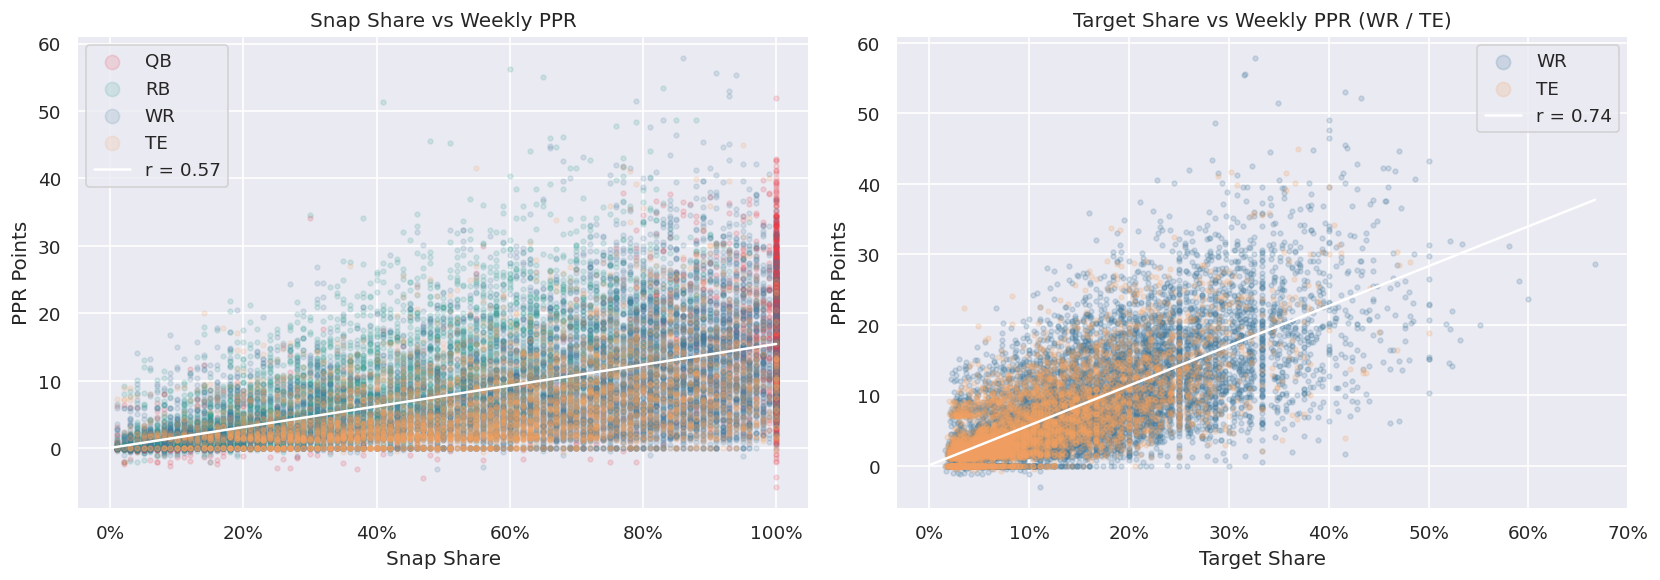

Snap share → PPR correlation  : r = 0.566  (p = 0.00e+00)
Target share → PPR correlation: r = 0.737


In [7]:
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Snap share vs PPR (all positions)
ax = axes[0]
snap_df = weekly.dropna(subset=["snap_share", "fantasy_points_ppr"])
for pos in POSITIONS:
    d = snap_df[snap_df.position == pos]
    ax.scatter(d.snap_share, d.fantasy_points_ppr,
               alpha=0.15, s=8, color=POSITION_COLORS[pos], label=pos)
# Regression line
m, b, r, p, _ = stats.linregress(snap_df.snap_share, snap_df.fantasy_points_ppr)
xs = np.linspace(0, 1, 100)
ax.plot(xs, m * xs + b, color="white", lw=1.5, label=f"r = {r:.2f}")
ax.set_title("Snap Share vs Weekly PPR")
ax.set_xlabel("Snap Share")
ax.set_ylabel("PPR Points")
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.legend(markerscale=3)

# Target share vs PPR (receivers only)
ax2 = axes[1]
rec_df = weekly[weekly.position.isin(["WR", "TE"])].dropna(subset=["target_share", "fantasy_points_ppr"])
for pos in ["WR", "TE"]:
    d = rec_df[rec_df.position == pos]
    ax2.scatter(d.target_share, d.fantasy_points_ppr,
                alpha=0.2, s=8, color=POSITION_COLORS[pos], label=pos)
m2, b2, r2, _, _ = stats.linregress(rec_df.target_share.fillna(0), rec_df.fantasy_points_ppr)
xs2 = np.linspace(0, rec_df.target_share.max(), 100)
ax2.plot(xs2, m2 * xs2 + b2, color="white", lw=1.5, label=f"r = {r2:.2f}")
ax2.set_title("Target Share vs Weekly PPR (WR / TE)")
ax2.set_xlabel("Target Share")
ax2.set_ylabel("PPR Points")
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax2.legend(markerscale=3)

plt.tight_layout()
plt.show()

print(f"Snap share → PPR correlation  : r = {r:.3f}  (p = {p:.2e})")
print(f"Target share → PPR correlation: r = {r2:.3f}")

## 6 · Week-by-week scoring trends

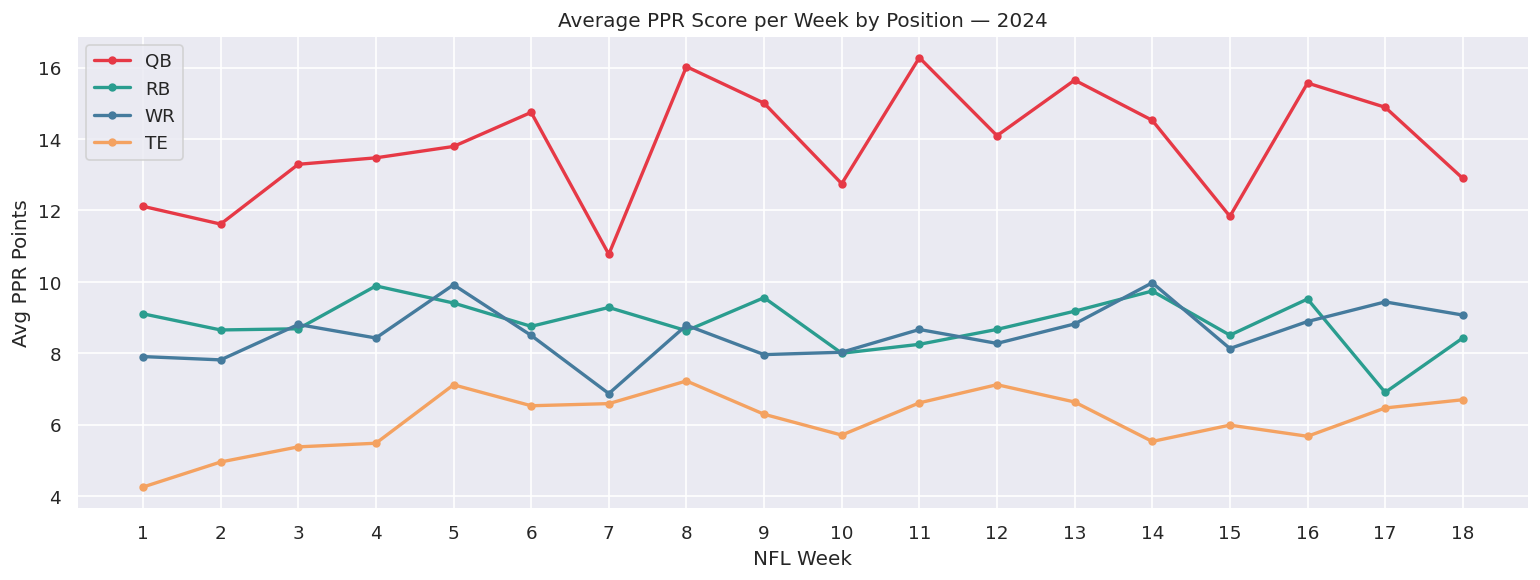

In [8]:
# Average weekly PPR by position and week (2024)
weekly_trend = (
    weekly[weekly.season == SEASON]
    .groupby(["week", "position"])["fantasy_points_ppr"]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(13, 5))
for pos in POSITIONS:
    d = weekly_trend[weekly_trend.position == pos]
    ax.plot(d.week, d.fantasy_points_ppr, marker="o", markersize=4,
            label=pos, color=POSITION_COLORS[pos], lw=2)

ax.set_title(f"Average PPR Score per Week by Position — {SEASON}")
ax.set_xlabel("NFL Week")
ax.set_ylabel("Avg PPR Points")
ax.set_xticks(sorted(weekly_trend.week.unique()))
ax.legend()
plt.tight_layout()
plt.show()

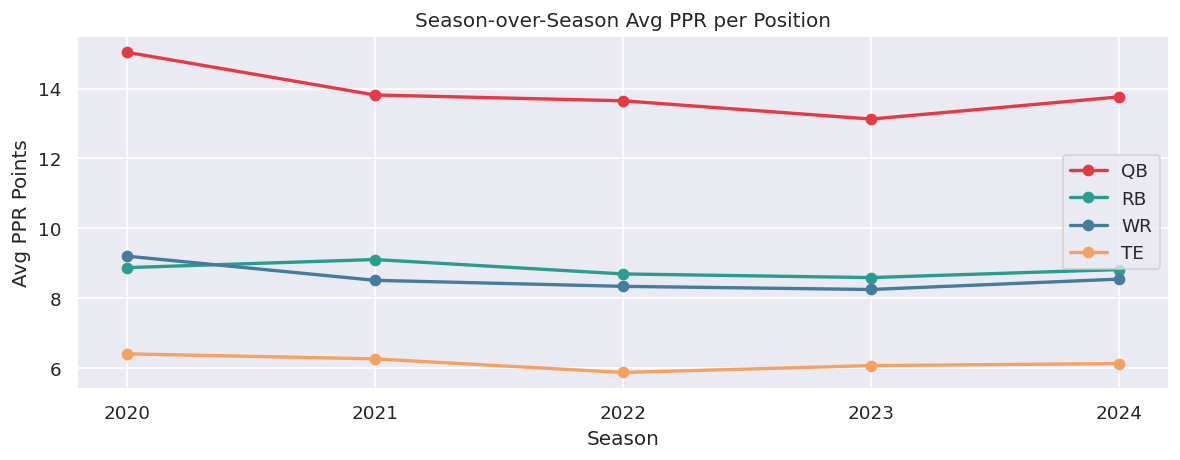

In [9]:
# Season-over-season average PPR
sos_trend = (
    weekly.groupby(["season", "position"])["fantasy_points_ppr"]
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 4))
for pos in POSITIONS:
    d = sos_trend[sos_trend.position == pos]
    ax.plot(d.season, d.fantasy_points_ppr, marker="o",
            label=pos, color=POSITION_COLORS[pos], lw=2)

ax.set_title("Season-over-Season Avg PPR per Position")
ax.set_xlabel("Season")
ax.set_ylabel("Avg PPR Points")
ax.set_xticks(sorted(weekly.season.unique()))
ax.legend()
plt.tight_layout()
plt.show()

## 7 · Position scarcity

How many truly startable players exist at each position each week?  
Startable = above the `avg_pts_startable` baseline (top 24 QB, 48 RB/WR, 24 TE).

Position scarcity — 2024

          avg_pts_all  avg_pts_startable    max_pts  scarcity_gap
position                                                         
QB              13.85              18.94  34.320000          5.09
RB               8.84              12.72  34.490002          3.88
TE               6.12              11.88  25.080000          5.76
WR               8.57              16.10  38.340000          7.53


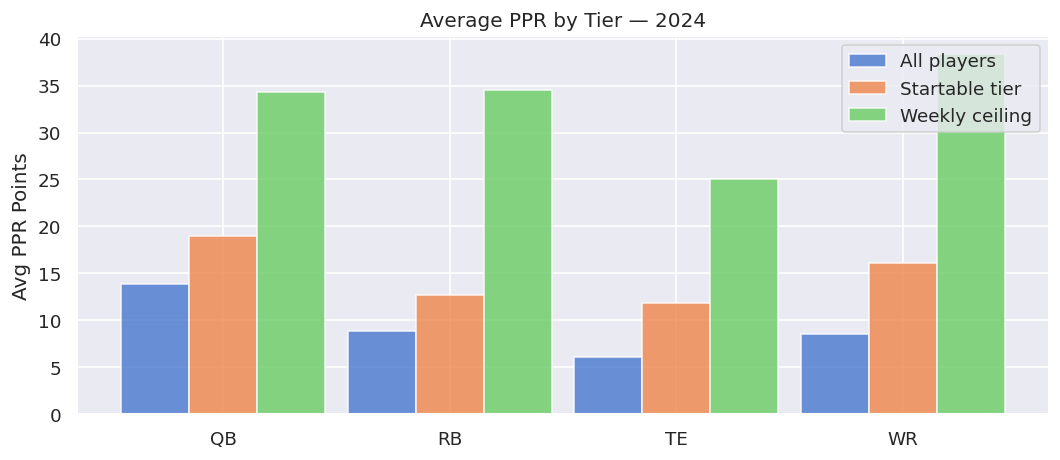

In [10]:
scarcity = (
    baseline[baseline.season == SEASON]
    .groupby("position")[["avg_pts_all", "avg_pts_startable", "max_pts"]]
    .mean()
    .round(2)
)
scarcity["scarcity_gap"] = (scarcity.avg_pts_startable - scarcity.avg_pts_all).round(2)
print(f"Position scarcity — {SEASON}\n")
print(scarcity.to_string())

fig, ax = plt.subplots(figsize=(9, 4))
x = np.arange(len(scarcity))
w = 0.3
ax.bar(x - w, scarcity.avg_pts_all,       w, label="All players",        alpha=0.8)
ax.bar(x,     scarcity.avg_pts_startable, w, label="Startable tier",     alpha=0.8)
ax.bar(x + w, scarcity.max_pts,           w, label="Weekly ceiling",     alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(scarcity.index)
ax.set_title(f"Average PPR by Tier — {SEASON}")
ax.set_ylabel("Avg PPR Points")
ax.legend()
plt.tight_layout()
plt.show()

## 8 · A/B experiment preview

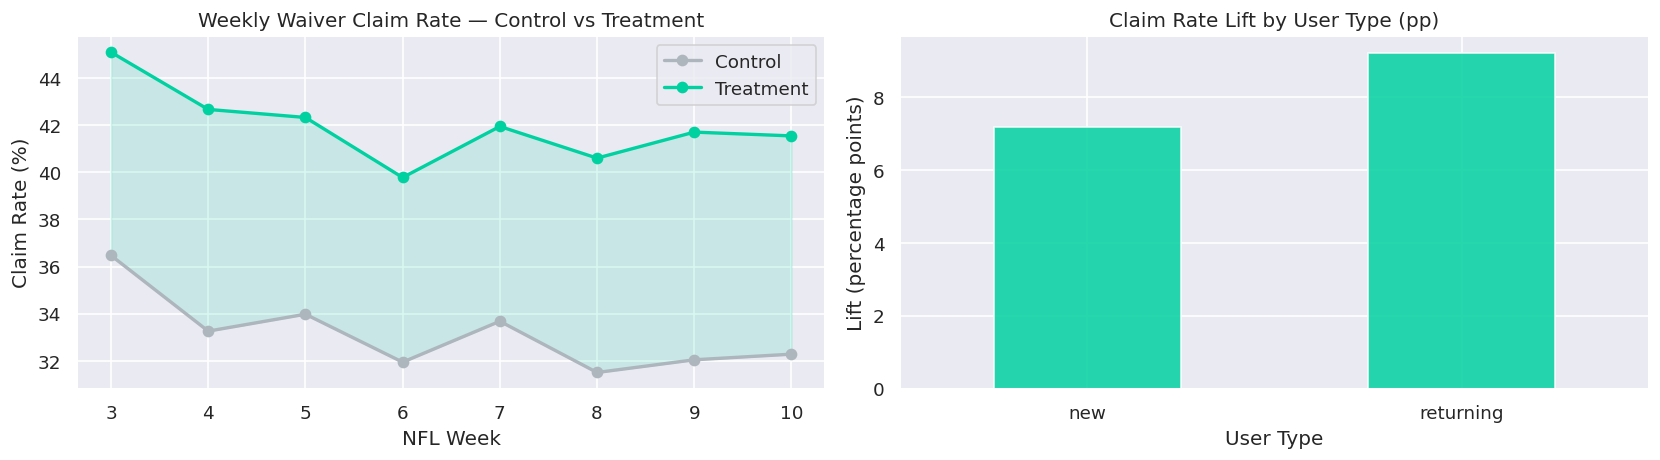

Control claim rate :  33.1%
Treatment claim rate: 42.0%
Absolute lift      : +8.81pp
Relative lift      : +26.6%


In [11]:
ab_events = con.execute("SELECT * FROM ab_events").df()

weekly_ab = (
    ab_events.groupby(["week", "variant"])
    .agg(claim_rate=("made_claim", "mean"), n=("made_claim", "count"))
    .reset_index()
)

ctrl = weekly_ab[weekly_ab.variant == "control"]
trt  = weekly_ab[weekly_ab.variant == "treatment"]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Claim rate over time
ax = axes[0]
ax.plot(ctrl.week, ctrl.claim_rate * 100, marker="o", label="Control",   color="#adb5bd", lw=2)
ax.plot(trt.week,  trt.claim_rate  * 100, marker="o", label="Treatment", color="#00d1a0", lw=2)
ax.fill_between(ctrl.week,
                ctrl.claim_rate * 100,
                trt.claim_rate  * 100,
                alpha=0.15, color="#00d1a0")
ax.set_title("Weekly Waiver Claim Rate — Control vs Treatment")
ax.set_xlabel("NFL Week")
ax.set_ylabel("Claim Rate (%)")
ax.legend()

# Lift by segment
ax2 = axes[1]
seg = (
    ab_events.groupby(["user_type", "variant"])["made_claim"]
    .mean()
    .unstack()
    .assign(lift=lambda d: (d.treatment - d.control) * 100)
)
seg.lift.plot(kind="bar", ax=ax2, color="#00d1a0", alpha=0.85, rot=0)
ax2.set_title("Claim Rate Lift by User Type (pp)")
ax2.set_xlabel("User Type")
ax2.set_ylabel("Lift (percentage points)")
ax2.axhline(0, color="gray", lw=0.8)

plt.tight_layout()
plt.show()

# Summary
overall = ab_events.groupby("variant")["made_claim"].mean()
lift = (overall["treatment"] - overall["control"]) * 100
print(f"Control claim rate :  {overall['control']:.1%}")
print(f"Treatment claim rate: {overall['treatment']:.1%}")
print(f"Absolute lift      : +{lift:.2f}pp")
print(f"Relative lift      : +{lift / (overall['control'] * 100) * 100:.1f}%")

In [12]:
con.close()